# TrendAnalysis object-oriented example


This juypter notebook is intended to demonstrate the RdTools analysis workflow as implemented with the `rdtools.TrendAnalysis` object-oriented API. For a consistent experience, we recommend installing the packages and versions documented in `docs/notebook_requirements.txt`. This can be achieved in your environment by running `pip install -r docs/notebook_requirements.txt` from the base directory. (RdTools must also be separately installed.) This notebook was tested in python 3.12.

The calculations consist of two phases:

1. Import and preliminary calculations: In this step data is important and augmented to enable analysis with RdTools. **No RdTools functions are used in this step. It will vary depending on the particulars of your dataset. Be sure to understand the inputs RdTools requires and make appropriate adjustments.**  
2. Analysis with RdTools: This notebook illustrates the use of the TrendAnalysis API to year on year (YOY) degradation and recovery (SRR) soiling calculations.

This notebook works with data from the NREL PVDAQ `[4] NREL x-Si #1` system.  Note that because this system does not experience significant soiling, the dataset contains a synthesized soiling signal for use in the soiling section of the example.  This notebook automatically downloads and locally caches the dataset used in this example. The data can also be found on the DuraMAT Datahub (https://datahub.duramat.org/dataset/pvdaq-time-series-with-soiling-signal).

An older version of this notebook (RdTools<3) included emphasis on the clear sky workflow which uses clear sky modeled irradiance rather than measured (sensor) irradiance for analysis. The clear sky analysis served to double check the sensor based result for things like sensor drift, but there was high uncertainty with this approach because aerosal optical depth (AOD), an input to the clear sky irradiance model, can change from year to year. Therefore we have de-emphasized the clear sky workflow in this version of the notebook. We also include a new notebook that illustrates the use of satellite irradiance data, which can serve as a check on the sensor-based analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
import rdtools
%matplotlib inline

In [2]:
#Update the style of plots
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })
# Register time series plotting in pandas > 1.0
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# Set the random seed for numpy to ensure consistent results
np.random.seed(0)

## Import and preliminary calculations


This section prepares the data necessary for an `rdtools` calculation.

A common challenge is handling datasets with and without daylight savings time. Make sure to specify a `pytz` timezone that does or does not include daylight savings time as appropriate for your dataset.

**The steps of this section may change depending on your data source or the system being considered. Note that nothing in this first section utilizes the `rdtools` library.** Transposition of irradiance and modeling of cell temperature are generally outside the scope of `rdtools`. A variety of tools for these calculations are available in [pvlib](https://github.com/pvlib/pvlib-python).

In [4]:
# Import the example data
file_url = ('https://datahub.duramat.org/dataset/'
            'a49bb656-7b36-437a-8089-1870a40c2a7d/'
            'resource/d2c3fcf4-4f5f-47ad-8743-fc29'
            'f1356835/download/pvdaq_system_4_2010'
            '-2016_subset_soil_signal.csv')
cache_file = 'PVDAQ_system_4_2010-2016_subset_soilsignal.pickle'

try:
    df = pd.read_pickle(cache_file)
except FileNotFoundError:
    df = pd.read_csv(file_url, index_col=0, parse_dates=True)
    df.to_pickle(cache_file)

In [5]:
df = df.rename(columns = {
    'ac_power':'power_ac',
    'wind_speed': 'wind_speed',
    'ambient_temp': 'Tamb',
    'poa_irradiance': 'poa',
})

# Specify the Metadata
meta = {"latitude": 39.7406,
        "longitude": -105.1774,
        "timezone": 'Etc/GMT+7',
        "gamma_pdc": -0.005,
        "azimuth": 180,
        "tilt": 40,
        "power_dc_rated": 1000.0,
        "temp_model_params":'open_rack_glass_polymer'}

df.index = df.index.tz_localize(meta['timezone'])

# Set the pvlib location
loc = pvlib.location.Location(meta['latitude'], meta['longitude'], tz = meta['timezone'])

# There is some missing data, but we can infer the frequency from
# the first several data points
freq = pd.infer_freq(df.index[:10])

This example dataset includes a synthetic soiling signal that can be applied onto the PV power data to illustrate the soiling loss and detection capabilities of RdTools.  AC Power is multiplied by soiling to create the synthetic 'power' channel

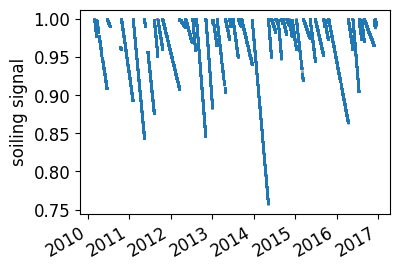

In [6]:
# Plot synthetic soiling signal attached to the dataset
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(df.index, df.soiling, 'o', alpha=0.01)
#ax.set_ylim(0,1500)
fig.autofmt_xdate()
ax.set_ylabel('soiling signal');
plt.show()

df['power'] = df['power_ac'] * df['soiling']

## Use of the object oriented system analysis API

The first step is to create a `TrendAnalysis` instance containing data to be analyzed and information about the system. Here we illustrate a basic applicaiton, but the API is highly customizable and we encourage you to read the docstrings and check the source for full details.

In [7]:
ta = rdtools.TrendAnalysis(df['power'], df['poa'],
                           temperature_ambient=df['Tamb'],
                           gamma_pdc=meta['gamma_pdc'],
                           interp_freq=freq,
                           windspeed=df['wind_speed'],
                           power_dc_rated=meta['power_dc_rated'],
                           temperature_model=meta['temp_model_params'])

Once the `TrendAnalysis` object is ready, the `sensor_analysis()` method can be used to deploy the full chain of analysis steps. Results are stored in nested dict, `TrendAnalysis.results`.

New in RdTools 3, there are two filtering steps. The first step occurs after normalization but before aggregation, and the second after aggregation. Filters utilized in the first filtering step can be adjusted by changing the dict `TrendAnalysis.filter_params`. Filters used in the second filtering step can be adjusted by changing the dict `TrendAnalysis.filter_params_aggregated`. 

Here we also illustrate how the aggregated data can be used to estimate soiling losses using the stochastic rate and recovery (SRR) method.<sup>1</sup> Since our example system doesn't experience much soiling, we apply an artificially generated soiling signal, just for the sake of example. If the dataset doesn't require special treatment, the 'srr_soiling' analysis type can just be added to the `sensor_analysis` function below. A warning is emitted here because the underlying RdTools soiling module is still experimental and subject to change.

<sup>1</sup>M. G. Deceglie, L. Micheli and M. Muller, "Quantifying Soiling Loss Directly From PV Yield," IEEE Journal of Photovoltaics, vol. 8, no. 2, pp. 547-551, March 2018. doi: 10.1109/JPHOTOV.2017.2784682

In [8]:
ta.sensor_analysis(analyses=['yoy_degradation','srr_soiling'])

c:\users\mspringe\onedrive - nrel\msp\pvfleets\repos\rdtools\rdtools\soiling.py:27: UserWarning: The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.
  warnings.warn(


The results of the calculations are stored in a nested dict, `TrendAnalysis.results`

In [9]:
yoy_results = ta.results['sensor']['yoy_degradation']
srr_results = ta.results['sensor']['srr_soiling']

In [10]:
# Print the sensor-based analysis p50 degradation rate and confidence interval
print(np.round(yoy_results['p50_rd'], 3))
print(np.round(yoy_results['rd_confidence_interval'], 3))

-0.501
[-0.611 -0.322]


In [11]:
# Print the p50 inoslation-weighted soiling ration and confidence interval
print(np.round(srr_results['p50_sratio'], 3))
print(np.round(srr_results['sratio_confidence_interval'], 3))

0.954
[0.95  0.957]


## Plotting
The `TrendAnalysis` class has built in methods for making useful plots

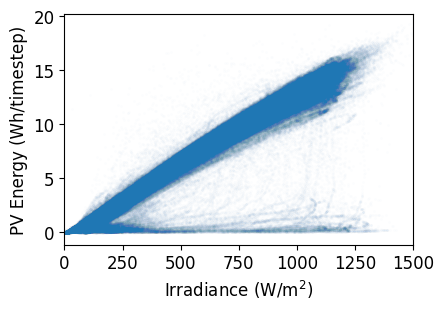

In [12]:
# check that PV energy is roughly proportional to irradiance
# Loops and other features in this plot can indicate things like
# time zone problems for irradiance transposition errors.
fig = ta.plot_pv_vs_irradiance('sensor')
plt.show()

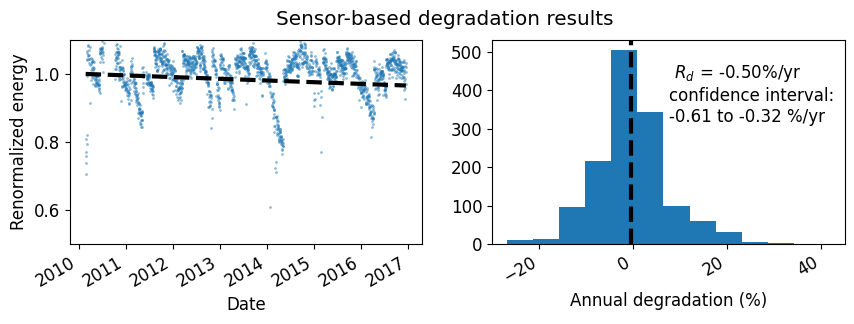

In [13]:
# Plot the sensor based degradation results
fig = ta.plot_degradation_summary('sensor', summary_title='Sensor-based degradation results',
                                  scatter_ymin=0.5, scatter_ymax=1.1,
                                  hist_xmin=-30, hist_xmax=45)
plt.show()

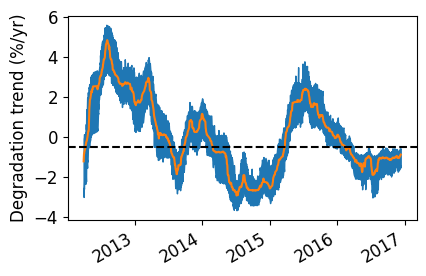

In [14]:
# Plot a time-dependent median (plus confidence interval) of sensor-based degradation results
fig = ta.plot_degradation_timeseries('sensor', rolling_days=365)
plt.show()

The TrendAnalysis class also has built-in methods for plots associated with soiling analysis

c:\users\mspringe\onedrive - nrel\msp\pvfleets\repos\rdtools\rdtools\plotting.py:173: UserWarning: The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.
  warnings.warn(


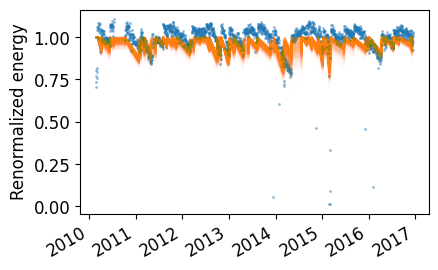

In [15]:
fig = ta.plot_soiling_monte_carlo('sensor', profile_alpha=0.01, profiles=500)
plt.show()

c:\users\mspringe\onedrive - nrel\msp\pvfleets\repos\rdtools\rdtools\plotting.py:233: UserWarning: The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.
  warnings.warn(


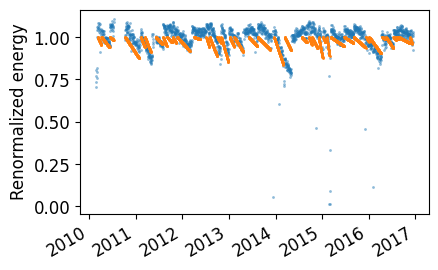

In [16]:
fig = ta.plot_soiling_interval('sensor')
plt.show()

c:\users\mspringe\onedrive - nrel\msp\pvfleets\repos\rdtools\rdtools\plotting.py:273: UserWarning: The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.
  warnings.warn(


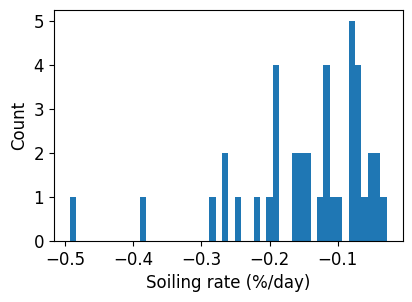

In [17]:
fig = ta.plot_soiling_rate_histogram('sensor', bins=50)
plt.show()

We can also view a table of the valid soiling intervals and associated metrics

In [18]:
interval_summary = ta.results['sensor']['srr_soiling']['calc_info']['soiling_interval_summary']
interval_summary[interval_summary['valid']].head()

,start,end,soiling_rate,soiling_rate_low,soiling_rate_high,inferred_start_loss,inferred_end_loss,length,valid
5,2010-03-10 00:00:00-07:00,2010-04-08 00:00:00-07:00,-0.001577,-0.003637,0.000000,1.063788,1.018062,29,True
6,2010-04-09 00:00:00-07:00,2010-06-11 00:00:00-07:00,-0.000955,-0.001237,-0.000640,1.024589,0.964412,63,True
9,2010-06-15 00:00:00-07:00,2010-07-13 00:00:00-07:00,-0.000594,-0.001868,0.000000,1.072710,1.056087,28,True
12,2010-10-11 00:00:00-07:00,2011-01-28 00:00:00-07:00,-0.001143,-0.001301,-0.001000,1.057288,0.932740,109,True
15,2011-02-11 00:00:00-07:00,2011-03-14 00:00:00-07:00,-0.001913,-0.002793,-0.001307,1.020735,0.961439,31,True


## Modifying and inspecting the filters
Filter parameters for the first filtering step can be adjusted from their default paramters by modifying the attribute `TrendAnalysis.filter_params`, which is a dict where the keys are names of functions in `rdtools.filtering`, and the values are a dict of the parameters for the associated filter. In the following example we modify the POA filter to have a low cutoff of 500 W/m^2 and use an alternate method in the clipping filter.

In [19]:
# Instantiate a new instance of TrendAnalysis
ta_new_filter = rdtools.TrendAnalysis(df['power'], df['poa'],
                                      temperature_ambient=df['Tamb'],
                                      gamma_pdc=meta['gamma_pdc'],
                                      interp_freq=freq,
                                      windspeed=df['wind_speed'],
                                      temperature_model=meta['temp_model_params'])

# Modify the poa and clipping filter parameters
ta_new_filter.filter_params['poa_filter'] = {'poa_global_low':500}
ta_new_filter.filter_params['clip_filter'] = {'model':'xgboost'}

# Run the YOY degradation analysis
ta_new_filter.sensor_analysis()

In [20]:
# We can inspect the filter components with the attributes sensor_filter_components and clearsky_filter_components
ta_new_filter.sensor_filter_components.head()

,normalized_filter,poa_filter,tcell_filter,clip_filter
2010-02-25 14:16:00-07:00,False,False,True,True
2010-02-25 14:17:00-07:00,True,False,True,True
2010-02-25 14:18:00-07:00,True,False,True,True
2010-02-25 14:19:00-07:00,True,False,True,True
2010-02-25 14:20:00-07:00,True,False,True,True


In [21]:
# and we can inspect the final filter sensor_filter and clearsky_filter
ta_new_filter.sensor_filter.head()

2010-02-25 14:16:00-07:00    False
2010-02-25 14:17:00-07:00    False
2010-02-25 14:18:00-07:00    False
2010-02-25 14:19:00-07:00    False
2010-02-25 14:20:00-07:00    False
Freq: min, dtype: bool

In [22]:
# NBVAL_IGNORE_OUTPUT
# Visualize the filter
# these visualiztions can take up a lot of memory
# so just look at small subset of the data for this example
rdtools.tune_filter_plot(ta_new_filter.pv_energy['2013/01/01':'2013/01/21'],
                         ta_new_filter.sensor_filter['2013/01/01':'2013/01/21'])

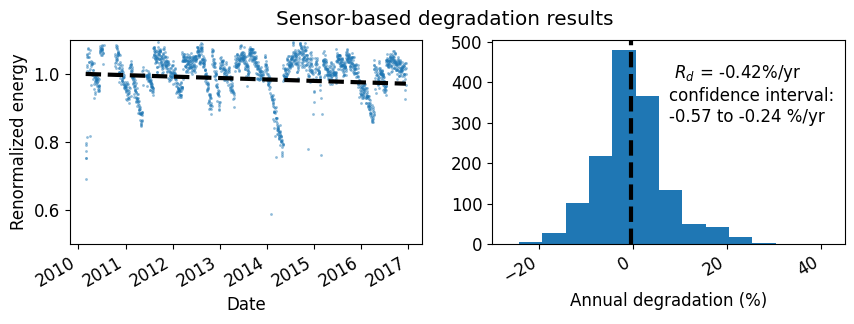

In [23]:
# Visualize the results
ta_new_filter.plot_degradation_summary('sensor', summary_title='Sensor-based degradation results',
                                   scatter_ymin=0.5, scatter_ymax=1.1,
                                   hist_xmin=-30, hist_xmax=45);
plt.show()

### Using externally calculated filters
Arbitrary filters can also be used by setting the `ad_hoc_filter` key of the `TrendAnalysis.filter_params` atribute to a boolean pandas series that can be used as a filter. In this example we filter for "stuck" values, i.e. values that are repeated consecuatively, which can be associated with faulty measurments.

In [24]:
def filter_stuck_values(pandas_series):
    '''
    Returns a boolean pd.Series which filters out sequentially
    repeated values from pandas_series'
    '''
    diff = pandas_series.diff()
    diff_shift = diff.shift(-1)

    stuck_filter = ~((diff == 0) | (diff_shift == 0))

    return stuck_filter

In [25]:
# Instantiate a new instance of TrendAnalysis
ta_stuck_filter = rdtools.TrendAnalysis(df['power'], df['poa'],
                                        temperature_ambient=df['Tamb'],
                                        gamma_pdc=meta['gamma_pdc'],
                                        interp_freq=freq,
                                        windspeed=df['wind_speed'],
                                        temperature_model=meta['temp_model_params'])

In [26]:
stuck_filter =  (
                  filter_stuck_values(df['power']) &
                  filter_stuck_values(df['poa']) &
                  filter_stuck_values(df['Tamb']) &
                  filter_stuck_values(df['wind_speed'])
                 )

# reindex onto the same index that will be used for the other filters
stuck_filter = stuck_filter.reindex(ta_stuck_filter.poa_global.index, fill_value=True)

ta_stuck_filter.filter_params['ad_hoc_filter'] = stuck_filter

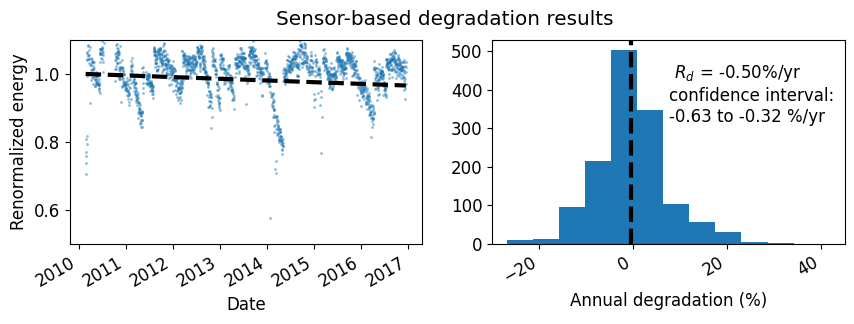

In [27]:
ta_stuck_filter.sensor_analysis()

# Visualize the results
ta_stuck_filter.plot_degradation_summary('sensor', summary_title='Sensor-based degradation results',
                                         scatter_ymin=0.5, scatter_ymax=1.1,
                                         hist_xmin=-30, hist_xmax=45);
plt.show()

### Using aggregated filters

RdTools 3 introduces a filtering step after aggregation. These filters can be manipulated through the `.filter_params_aggregated` attribute| of the TrendAnalysis object. With each key being the name of an aggregated filter and it's value a dict of parameters to pass to the filtering fucntion. By default, TrendAnalysis uses the `two_way_window_filter`

In [28]:
ta.filter_params_aggregated

{'two_way_window_filter': {}, 'ad_hoc_filter': None}

The aggregated filters can be manipulated following the same API as in the first filtering step. To see which points were removed by the two_way_window filter, we can remove that key from `.filter_params_aggregated` and re-run the degradation analysis. 

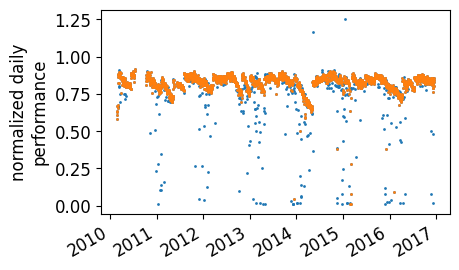

In [29]:
aggregated_performance_original = ta.sensor_aggregated_performance.copy()
ta.filter_params_aggregated.pop('two_way_window_filter')
ta.sensor_analysis()

fig, ax = plt.subplots()
ax.plot(ta.sensor_aggregated_performance.index, ta.sensor_aggregated_performance, 'o')
ax.plot(aggregated_performance_original.index, aggregated_performance_original, 'o')
ax.set_ylabel('normalized daily\nperformance')
fig.autofmt_xdate()
plt.show()

The result without the aggregated filtering step can be visualized as before

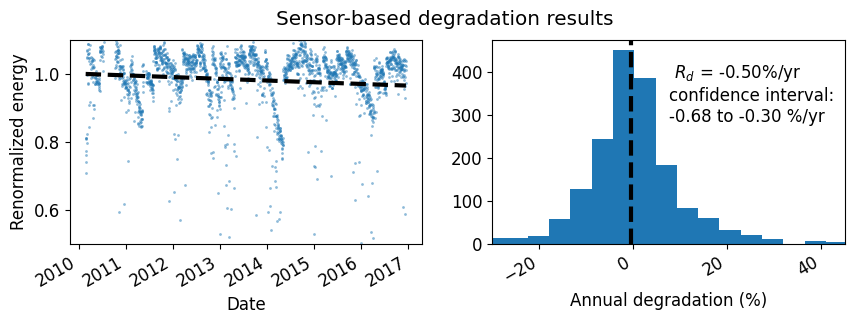

In [30]:
fig = ta.plot_degradation_summary('sensor', summary_title='Sensor-based degradation results',
                                  scatter_ymin=0.5, scatter_ymax=1.1,
                                  hist_xmin=-30, hist_xmax=45)
plt.show()

## CODS

This section gives an introduction to the <b>Combined Degradation and Soiling (CODS)</b> algorithm workflow, which can use the aggregated time series available in the TrendAnalysis object. For more information about CODS, we refer to [1] and [2].

CODS can be run in two ways - either by setting up an instance of `rdtools.soiling.CODSAnalysis` and running the method `run_bootstrap`, or by directly running `rdtools.soiling.soiling_cods`. Here we will show how to do the first option, as this makes more information available, and since the second option is more straightforward. We start by setting up an instance of `rdtools.soiling.CODSAnalysis`

[1]  Skomedal, Å. and Deceglie, M. G. IEEE J. of Photovoltaics, Sept. 2020
[2]  Skomedal, Å., Deceglie, M. G., Haug, H., and Marstein, E. S., Proceedings of the 37th European Photovoltaic Solar Energy Conference and Exhibition, Sept. 2020



In [31]:
from rdtools.soiling import CODSAnalysis
np.random.seed(0) # improves consistency with other notebook when using a low number of monte carlo reps
CODS = CODSAnalysis(aggregated_performance_original)

We continue to run `run_bootstrap`. The parameter `reps` decides how many repetitions of the bootstrapping procedure should be performed. `reps` needs to be a multiple of 16, and the minimum is 16. However, to give real confidence intervals, we recommend running it with 512 repetitions. In this case we use 16 to to avoid overly much time use. The parameter `verbose` decides whether to output information about the process during the calculation. `bootstrap_seed=42` ensures the same results from the bootstrap sampling each time, used here only for notebook testing.

In [32]:
results_df, degradation, soiling_loss = CODS.run_bootstrap(reps=16, bootstrap_seed=42)

In [33]:
df_out, CODS_results_dict = \
    CODS.iterative_signal_decomposition()
df_out.head()

,soiling_ratio,soiling_rates,cleaning_events,seasonal_component,degradation_trend,total_model,residuals
2010-02-25 00:00:00-07:00,0.632635,0.024614,True,0.999650,1.000000,0.547342,0.963029
2010-02-26 00:00:00-07:00,0.657248,0.024612,False,0.999475,0.999993,0.568532,0.889424
2010-02-27 00:00:00-07:00,0.681860,0.024611,False,0.999299,0.999986,0.589713,0.934689
2010-02-28 00:00:00-07:00,0.706470,0.024609,False,0.999122,0.999978,0.610885,0.945476
2010-03-01 00:00:00-07:00,0.731079,0.024608,False,0.998944,0.999971,0.632047,0.857710


Visualize the results

In [34]:
# The average soiling loss over the period with 95 % confidence intervals
# can be accessed through the soiling_loss attribute of CODS
soiling_loss = CODS.soiling_loss
print(f'Avg. Soiling loss {soiling_loss[0]:.3f} ({soiling_loss[1]:.3f}, {soiling_loss[2]:.3f}) (%)')

# The estimated degradatio rate over the period with 95 % confidence intervals
# can be accessed through the degradation attribute of CODS
degradation = CODS.degradation
print(f'Degradation rate {degradation[0]:.3f} ({degradation[1]:.3f}, {degradation[2]:.3f}) (%)')

Avg. Soiling loss 6.128 (4.569, 6.238) (%)
Degradation rate -0.181 (-0.371, -0.027) (%)


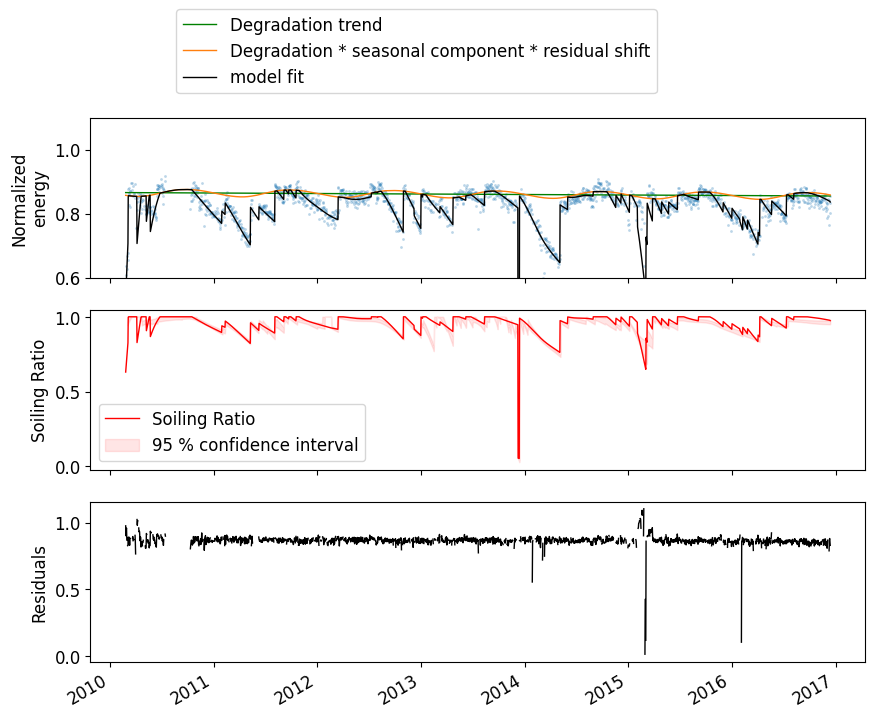

In [35]:
# The dataframe containing the time series of the different component fits
# can be accessed through CODS.result_df
result_df = CODS.result_df

# Let us plot the time series of the results
# First: daily normalized energy along with the total model fit and degradation trend
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
ax1.plot(aggregated_performance_original.index, aggregated_performance_original, 'o', alpha = 0.3)
ax1.plot(result_df.index, result_df.degradation_trend * CODS.residual_shift, color='g', linewidth=1,
         label='Degradation trend')
ax1.plot(result_df.index, result_df.degradation_trend * result_df.seasonal_component * CODS.residual_shift,
         color='C1', linewidth=1, label='Degradation * seasonal component * residual shift')
ax1.plot(result_df.index, result_df.total_model, color='k', linewidth=1,
         label='model fit')
ax1.set_ylim(0.6, 1.1)
ax1.set_ylabel('Normalized\nenergy')
ax1.legend(bbox_to_anchor=(0.1, 1.1))

# Second: soiling ratio with 95 % confidence intervals
ax2.plot(result_df.index, result_df.soiling_ratio, color='r', linewidth=1,
         label='Soiling Ratio')
ax2.fill_between(result_df.index, result_df.SR_low, result_df.SR_high,
                 color='r', alpha=.1, label='95 % confidence interval')
ax2.set_ylabel('Soiling Ratio')
ax2.legend()

# Third: The residuals
ax3.plot(result_df.index, result_df.residuals, color='k', linewidth=1)
ax3.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.show()